In [ ]:
#Import required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

<h1> Section 1) Fetch of the Kaggle Cats vs Dogs dataset




In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   103M      0  0:00:07  0:00:07 --:--:-- 99.2M


In [ ]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [ ]:
#Check the dataset folder, we can see there are 2 categories that cat and dog
!ls PetImages

Cat  Dog


<h1> Section 2) Coding of the convolutional neural network from scratch 

In [ ]:
#Filter out corrupted images and remove them
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
#Generate a Dataset from the images
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


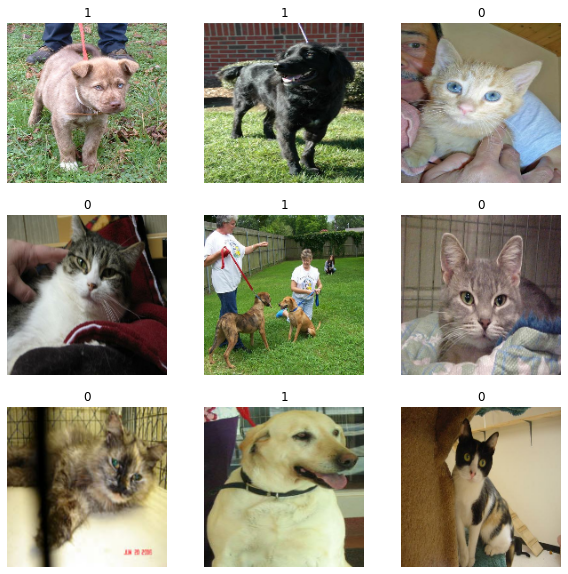

In [ ]:
#Visualize the the first 9 images in the training dataset.  (label 1 is "dog" and label 0 is "cat")
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
#Using image data augmentation to introduce sample diversity
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

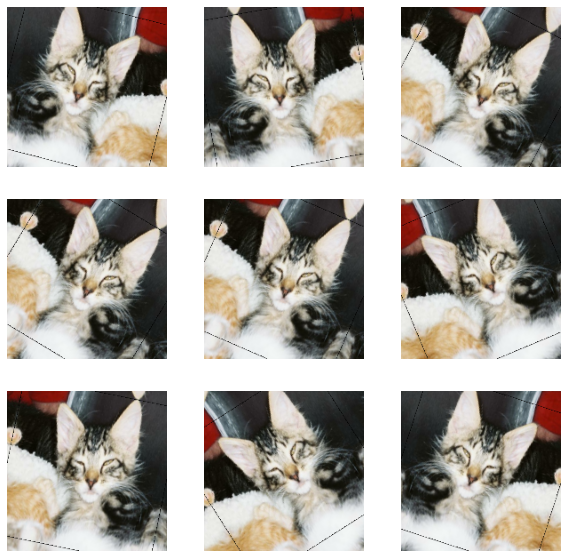

In [ ]:
#Visualize the data augmentation result on an image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
#Standardizing the data, transfer RGB values from [0, 255] to [0, 1]
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
#Configure the dataset for performance
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

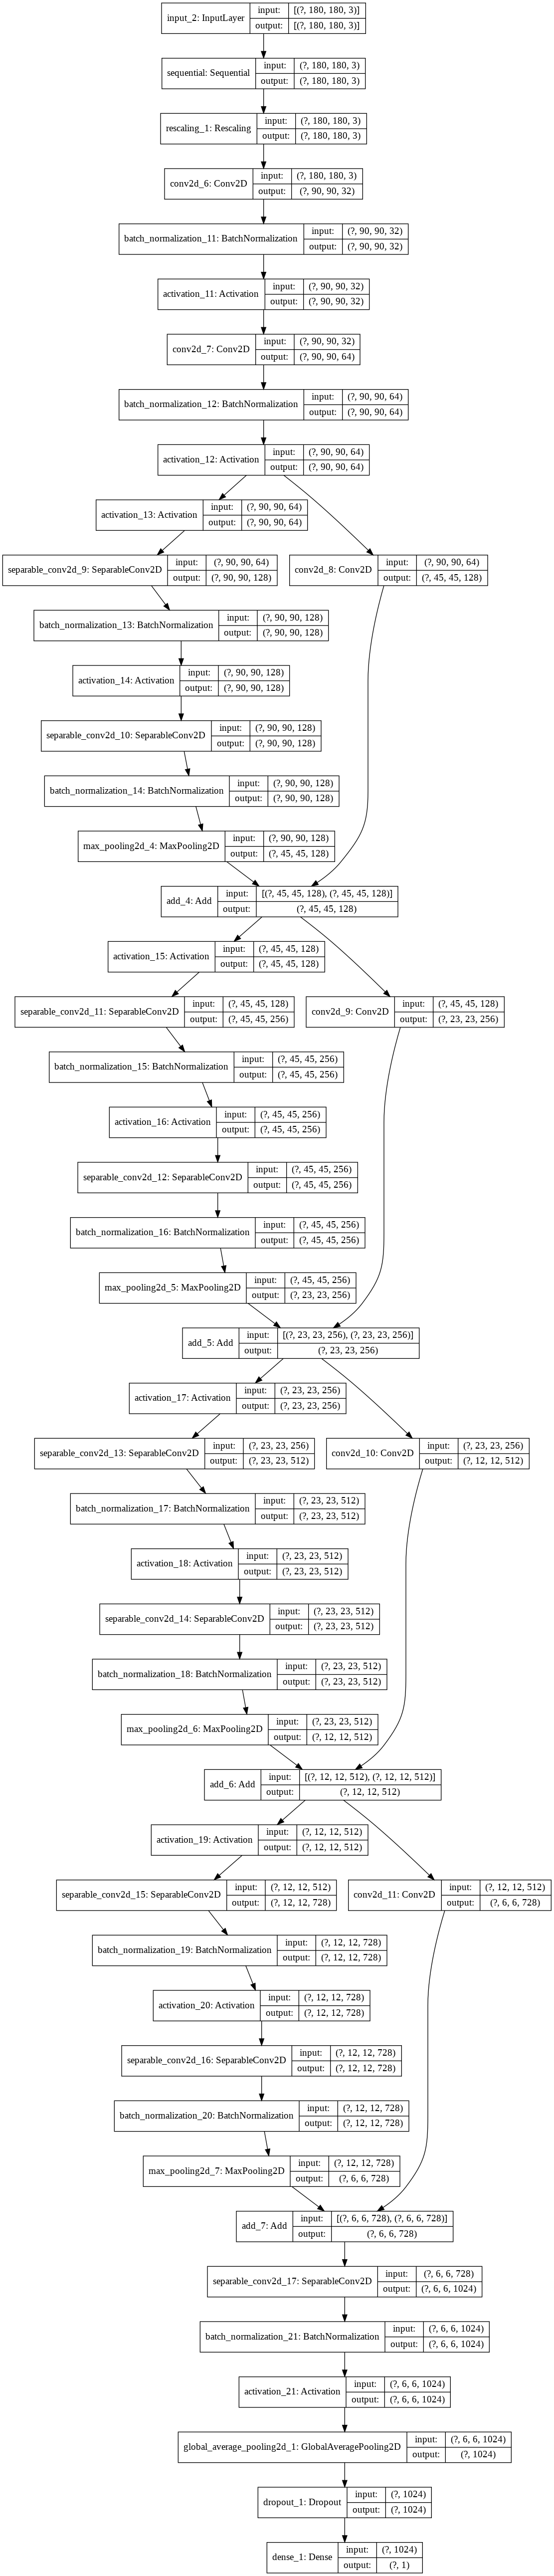

In [ ]:
#Build the Xception network model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

<h1> Section 3) Calculation of the accuracy of the model with 25 epochs and then 50 epochs

In [30]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/25
586/586 [==============================] - 156s 266ms/step - loss: 0.6238 - accuracy: 0.6578 - val_loss: 0.5960 - val_accuracy: 0.6715
Epoch 2/25
586/586 [==============================] - 155s 264ms/step - loss: 0.4644 - accuracy: 0.7788 - val_loss: 0.7796 - val_accuracy: 0.7104
Epoch 3/25
586/586 [==============================] - 155s 265ms/step - loss: 0.3589 - accuracy: 0.8437 - val_loss: 0.3427 - val_accuracy: 0.8560
Epoch 4/25
586/586 [==============================] - 155s 264ms/step - loss: 0.2928 - accuracy: 0.8752 - val_loss: 0.2873 - val_accuracy: 0.8866
Epoch 5/25
586/586 [==============================] - 154s 262ms/step - loss: 0.2451 - accuracy: 0.8975 - val_loss: 0.3389 - val_accuracy: 0.8501
Epoch 6/25
586/586 [==============================] - 154s 262ms/step - loss: 0.2133 - accuracy: 0.9110 - val_loss: 0.2094 - val_accuracy: 0.9141
Epoch 7/25
586/586 [==============================] - 153s 262ms/step - loss: 0.1997 - accuracy: 0.9165 - val_loss: 0.2481 -

<h1>Section 4) Code an option that prompts the user for an image online (user to write the full URL of an image)




<h3> Sorry! Since the limitation of my python skill and after countless experiments, I can only let the user enter url and get the image just like how we get the dataset. The following analysis and prediction are also base on this colab environment. But I offer the codes that enable user to download the image from colab environment to local environment

In [45]:
# Get the image from URL and save it in colab environment
!curl -O https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/german-shepherd-dog-royalty-free-image-806942944-1560893738.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  203k  100  203k    0     0  1476k      0 --:--:-- --:--:-- --:--:-- 1476k


In [47]:
#Check the downloaded image
!ls german-shepherd-dog-royalty-free-image-806942944-1560893738.jpg

german-shepherd-dog-royalty-free-image-806942944-1560893738.jpg


<h1> Section 5) Run your predictor model in the image from the URL submitted by the user and provide the best classification of whether the image is a dog or a cat.


In [48]:
#Use the image to predict and we can see the classifier give the right answer we can 94.31% sure this is a dog
img = keras.preprocessing.image.load_img(
    "german-shepherd-dog-royalty-free-image-806942944-1560893738.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 5.69 percent cat and 94.31 percent dog.


In [74]:
#User can download the tested image to their local environment
from google.colab import files
files.download('german-shepherd-dog-royalty-free-image-806942944-1560893738.jpg') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>